# Image Analytics Pipeline 📸
### 🔹 Neural Image Assessment | Clustering Model Selection & Results | DeepFace Analysis ｜ Logo Detection







## Part 1: Setup & Preparation

In [ ]:
# 1.1 Install Packages
!pip install tensorflow==2.15.0 keras==2.15.0 deepface
!pip install torch torchvision
!pip install clip open_clip_torch
!pip install transformers
!pip install openai
!pip install tqdm
!pip install category_encoders
!pip install scikit-learn
!pip install scipy
!pip install matplotlib
!pip install pandas
!pip install pillow
! pip install clip
! pip install deepface

In [ ]:
# 1.2 Import Packages
# If any package fails to import, simply add an install command in the cell above.
# Example: add '!pip install openai' if the 'openai' package is missing.

# Computing & Deep Learning
import torch
import tensorflow as tf
from tensorflow import keras
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn  # Neural network module

# Image Processing
from PIL import Image

# Machine Learning & NLP
from transformers import ViTImageProcessor, ViTModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from category_encoders import TargetEncoder

# Statistical Analysis
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization & Numerical Computation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import base64

# Utility Libraries
from tqdm import tqdm
from pathlib import Path
from openai import OpenAI
from deepface import DeepFace
from google.colab import files



import open_clip
import csv
import base64


In [ ]:
# 1.3 Set Device
def get_device():
    """
    Get the best available device for PyTorch operations.
    Returns: torch.device
    Priority: CUDA > MPS > CPU
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

# Get the device
device = get_device()
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# get the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### 1.4 Load Data
# get the image data
def get_image_paths_os(directory):
    image_paths = []
    for filename in os.listdir(directory):
        full_path = os.path.join(directory, filename)
        image_paths.append(full_path)
    return sorted(image_paths)

# 📂 Enter the path where your images are stored in Google Drive
base_directory = base_directory = ""
paths_list = get_image_paths_os(base_directory)

# Print total count
if paths_list:
    print(f"\n✅ Total images found: {len(paths_list)}")
else:
    print("\n⚠️ No images found. Please check the directory path and try again.")


✅ Total images found: 105


In [ ]:
# get the weight data for NIMA score through upload
uploaded = files.upload()
#file_name = "dense121_all.pt"

Saving dense121_all (1).pt to dense121_all (1).pt


## Part 2: Neural Image Assessment

### 2.1 Define Rating Function

In [ ]:
def rate(img_path, temperature=1.0):
    """
    Returns: Scores, mean, std
    """
    # Number of classes in the dataset
    num_classes = 10

    # Build model
    model_ft = models.densenet121(pretrained=True)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Sequential(
        nn.Linear(num_ftrs, num_classes)
    )

    # Weight Path
    weight_path = 'dense121_all.pt'

    # Load weights with map_location to CPU
    assert os.path.exists(weight_path), f"Weight file not found: {weight_path}"
    model_ft.load_state_dict(torch.load(weight_path, map_location=torch.device('cpu')))

    # Open and convert image to RGB
    img = Image.open(img_path).convert('RGB')

    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    img = transform(img)

    with torch.no_grad():
        scores = model_ft(img.view(1, 3, 224, 224))

        # **Apply Temperature Scaling to Softmax**
        scores = torch.nn.functional.softmax(scores / temperature, dim=1)

        weighted_votes = torch.arange(1, 11, dtype=torch.float)  # [1, 2, ..., 10]
        mean = torch.matmul(scores, weighted_votes)
        std = torch.sqrt((scores * torch.pow((weighted_votes - mean.view(-1, 1)), 2)).sum(dim=1))

    return scores.view(-1).numpy(), mean.item(), std.item()


### 2.2 Calculate & Display Results

  0%|          | 0/105 [00:00<?, ?it/s]Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth

  0%|          | 0.00/30.8M [00:00<?, ?B/s]
 19%|█▉        | 5.88M/30.8M [00:00<00:00, 61.5MB/s]
100%|██████████| 30.8M/30.8M [00:00<00:00, 113MB/s]
100%|██████████| 105/105 [00:49<00:00,  2.11it/s]


✅ NIMA Scores have been calculated


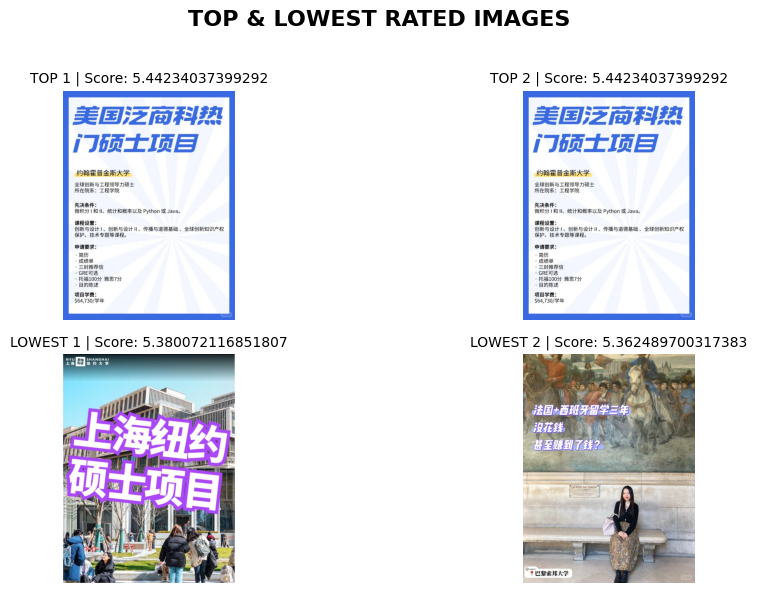

In [ ]:
nima_scores = []
for i in tqdm(paths_list):
    try:
        scores, mean, std = rate(i)
        nima_scores.append(mean)
    except Exception as e:
        print("Error processing image:", i)
        print("Exception:", e)
mean_score = np.mean(nima_scores)

if nima_scores:
    print(f"✅ NIMA Scores have been calculated")
else:
    print("⚠️ There are some issues, please check the code and try again")

# Convert scores and paths into a sorted list
sorted_images = sorted(zip(nima_scores, paths_list), reverse=True, key=lambda x: x[0])

# Get the top 2 highest scores
top_2 = sorted_images[:2]
bottom_2 = sorted_images[-2:]

# Print scores and display images
plt.figure(figsize=(12, 6))
plt.suptitle("TOP & LOWEST RATED IMAGES", fontsize=16, fontweight="bold")

for i, (score, img_path) in enumerate(top_2, 1):
    img = Image.open(img_path)  # Load image
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"TOP {i} | Score: {score}", fontsize=10)

# Bottom Images
for i, (score, img_path) in enumerate(bottom_2, 1):
    img = Image.open(img_path)  # Load image
    plt.subplot(2, 2, i + 2)  # Shift to next row
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"LOWEST {i} | Score: {score}", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


## Part 3: Clustering Model

### 3.1 Embedding

In [ ]:
# load VIT model from open clip
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model = model.to(device)
model = model.eval()

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
def preprocess_image(image_path):
    # Open image and convert to RGB to ensure 3 channels
    try:
        image = Image.open(image_path).convert('RGB')
        return image
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

def get_embedding(data_paths, save = 100, save_path = None):
  embedding = []
  count = 0
  for i in tqdm(range(len(data_paths))):
      if count % save == 0:
          print('saving', count)
          with open(save_path, 'w') as f:
              json.dump(embedding, f)
      count += 1
      try:
          # Preprocess the image
          image = preprocess_image(data_paths[i])

          if image is None:
              print(f"Skipping image {i} due to preprocessing error")
              continue

          # Process with the model
          with torch.no_grad():
            inputs = processor(images=image, return_tensors="pt")
            inputs = inputs.to(device)
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state
            cls = last_hidden_states[:, 0, :]

            embedding.append({
                'file': data_paths[i],
                'embedding': cls.cpu().detach().numpy().tolist()
            })

      except Exception as e:
          print(f"Error processing image {i} ({data_paths[i]}): {str(e)}")
          continue
  print('final saving')
  with open(save_path, 'w') as f:
      json.dump(embedding, f)
  print(f"Successfully processed {len(embedding)} images out of {len(data_paths)}")
  return embedding

# Modify the save path to your own Google Drive directory!
# The path displayed below is an example(my path:), you can aslo name it embedding_stratified_1.json or whatever you like
embedding = get_embedding(paths_list, save = 100, save_path = '')

  0%|          | 0/105 [00:00<?, ?it/s]

saving 0


 95%|█████████▌| 100/105 [01:05<00:03,  1.44it/s]

saving 100


100%|██████████| 105/105 [01:08<00:00,  1.53it/s]

final saving
Successfully processed 105 images out of 105


In [ ]:
# read embedding from all data
embedding = []
# also modify the path to your own Google Drive directory
with open('', 'r') as f:
    embedding = json.load(f)

# check embedding shape
print(len(embedding[0]['embedding']))
print(len(embedding))

### 3.2 Dimension reduction

Shape of data before t-SNE: (105, 768)
Shape of data after t-SNE: (105, 2)


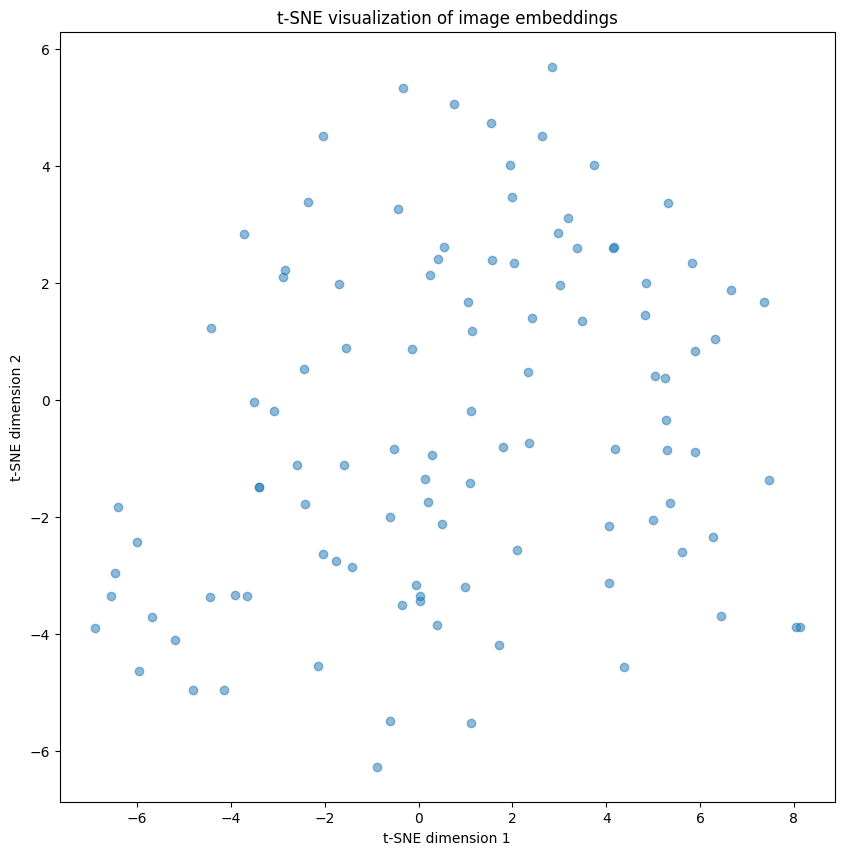

In [ ]:
# First, let's prepare the data by extracting embeddings and filenames
X = np.array([item['embedding'] for item in embedding])
filenames = [item['file'] for item in embedding]

# Reshape the embeddings if needed (from 1x768 to just 768 features)
X = X.squeeze()  # This will remove the extra dimension if present

# normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Shape of data before t-SNE:", X.shape)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(len(embedding)-1, 30))
X_tsne = tsne.fit_transform(X)

print("Shape of data after t-SNE:", X_tsne.shape)

# Create a dictionary or list to store the results
tsne_results = []
for i, (x, y) in enumerate(X_tsne):
    tsne_results.append({
        'file': filenames[i],
        'x': float(x),
        'y': float(y)
    })

# Optional: Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
plt.title('t-SNE visualization of image embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

### 3.3 K-means Clustering

New shape: (105, 2)
Testing k=2
Testing k=3
Testing k=4
Testing k=5
Testing k=6
Testing k=7
Testing k=8
Testing k=9
Testing k=10


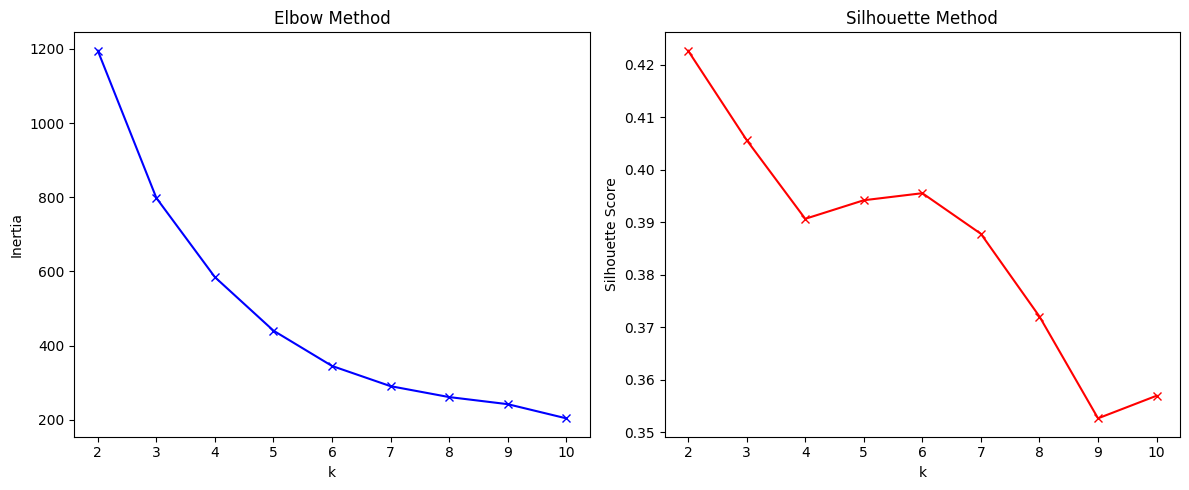

In [ ]:
# First, let's find the optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K = range(2, 11)  # Try 2 to 10 clusters

# Reshape the array to 2D
# If your data is shaped like (n_samples, dim1, dim2), you can reshape to (n_samples, dim1*dim2)
X_tsne_reshaped = X_tsne.reshape(X_tsne.shape[0], -1)
print("New shape:", X_tsne_reshaped.shape)

for k in K:
    print(f"Testing k={k}")
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tsne_reshaped)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_tsne_reshaped, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))

# Inertia plot
plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.tight_layout()
plt.show()

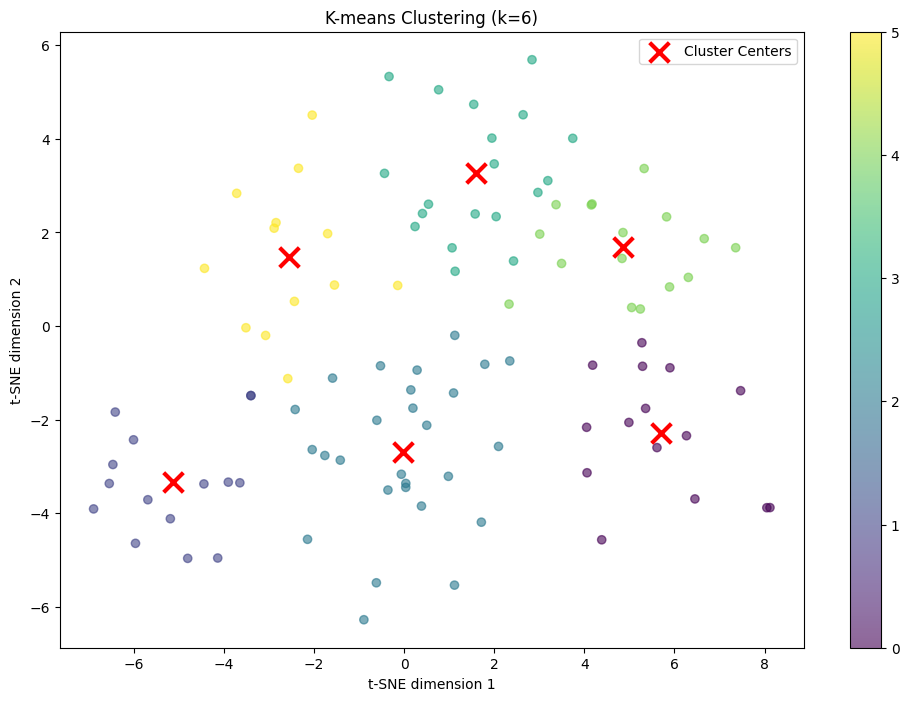

Cluster 0: 15 images
Cluster 1: 15 images
Cluster 2: 27 images
Cluster 3: 19 images
Cluster 4: 16 images
Cluster 5: 13 images


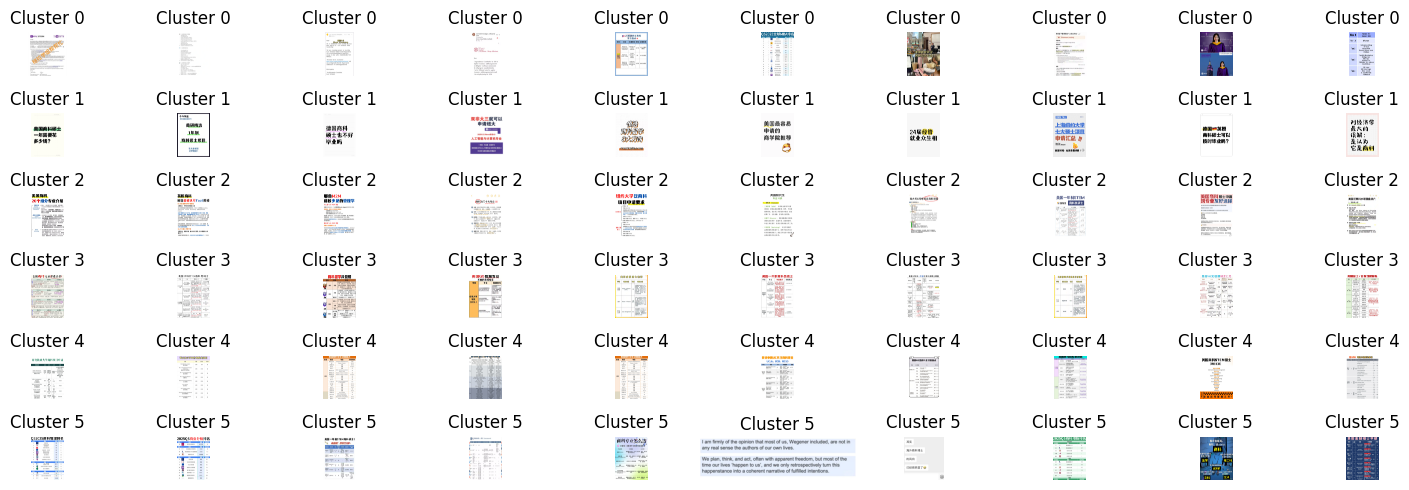

Cluster 0 center image: /content/drive/My Drive/Marketing Analytics Course Preparation/Qianyu/Modified Image & Text Analytics Code/Image Analytics/images/65d82ae0000000000700583b.jpg
Cluster 1 center image: /content/drive/My Drive/Marketing Analytics Course Preparation/Qianyu/Modified Image & Text Analytics Code/Image Analytics/images/66eac588000000000c01a1dd.jpg
Cluster 2 center image: /content/drive/My Drive/Marketing Analytics Course Preparation/Qianyu/Modified Image & Text Analytics Code/Image Analytics/images/669e2fc5000000000a0072c4.jpg
Cluster 3 center image: /content/drive/My Drive/Marketing Analytics Course Preparation/Qianyu/Modified Image & Text Analytics Code/Image Analytics/images/670909fc000000001902e2c8.jpg
Cluster 4 center image: /content/drive/My Drive/Marketing Analytics Course Preparation/Qianyu/Modified Image & Text Analytics Code/Image Analytics/images/6708d34f000000002c02b67d.jpg
Cluster 5 center image: /content/drive/My Drive/Marketing Analytics Course Preparatio

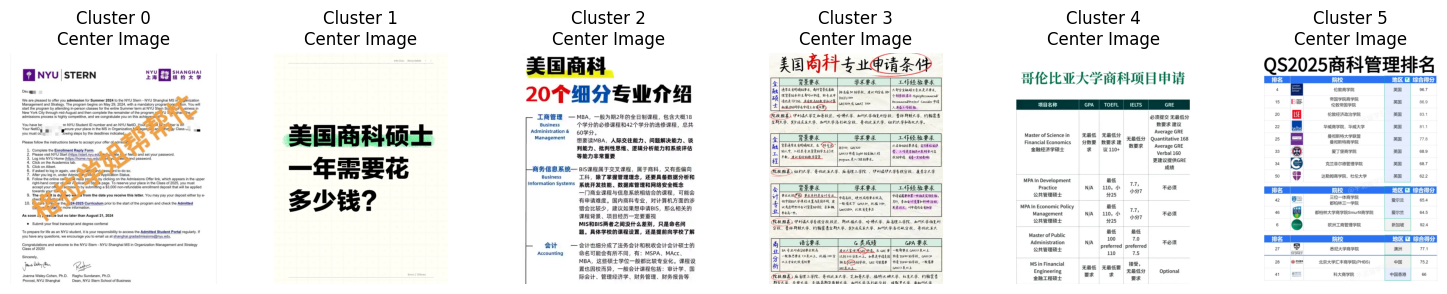

In [ ]:
# After examining the elbow curve, apply KMeans with the optimal k
# Identify the optimal k where the inertia decrease speed becomes noticibly smaller || Silhouette Score is the highest
optimal_k = 6  # You should adjust this based on the elbow curve

# Apply KMeans with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_tsne)

# Visualize the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels,
                     cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title(f'K-means Clustering (k={optimal_k})')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')

# Add cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x',
            s=200, linewidth=3, label='Cluster Centers')
plt.legend()
plt.show()

# Create a dictionary to store results
clustering_results = []
for i in range(len(X_tsne)):
    clustering_results.append({
        'file': filenames[i],
        'x': float(X_tsne[i, 0]),
        'y': float(X_tsne[i, 1]),
        'cluster': int(cluster_labels[i])
    })

# Print summary of clusters
for cluster in range(optimal_k):
    cluster_size = np.sum(cluster_labels == cluster)
    print(f"Cluster {cluster}: {cluster_size} images")

# Optional: Save the results
import json
with open('clustering_results.json', 'w') as f:
    json.dump(clustering_results, f)

# Function to find representative images for each cluster
def get_cluster_representatives(cluster_id, n_samples=5):
    # Get points in this cluster
    cluster_points = X_tsne[cluster_labels == cluster_id]
    cluster_files = [f for i, f in enumerate(filenames) if cluster_labels[i] == cluster_id]

    # Find points closest to cluster center
    center = kmeans.cluster_centers_[cluster_id]
    distances = np.linalg.norm(cluster_points - center, axis=1)
    representative_indices = np.argsort(distances)[:n_samples]

    return [cluster_files[i] for i in representative_indices]

# Plot the images
plt.figure(figsize=(15, 5))
for cluster in range(optimal_k):
    representatives = get_cluster_representatives(cluster, 10)
    for idx, img_path in enumerate(representatives):
        plt.subplot(optimal_k, len(representatives), cluster * len(representatives) + idx + 1)
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Cluster {cluster}')
plt.tight_layout()
plt.show()

# plot the center images
# Function to find the single most representative image (closest to center) for each cluster
def get_center_image(cluster_id):
    # Get points in this cluster
    cluster_mask = cluster_labels == cluster_id
    cluster_points = X_tsne[cluster_mask]
    cluster_files = np.array(filenames)[cluster_mask]

    # Find point closest to cluster center
    center = kmeans.cluster_centers_[cluster_id]
    distances = np.linalg.norm(cluster_points - center, axis=1)
    center_idx = np.argmin(distances)

    return cluster_files[center_idx]
# Plot only the center images
plt.figure(figsize=(15, 3))
for cluster in range(optimal_k):
    plt.subplot(1, optimal_k, cluster + 1)
    center_image_path = get_center_image(cluster)

    # Read and display the image
    try:
        img = plt.imread(center_image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Cluster {cluster}\nCenter Image')
        print(f"Cluster {cluster} center image: {center_image_path}")
    except Exception as e:
        print(f"Error loading image for cluster {cluster}: {e}")
        plt.text(0.5, 0.5, 'Image Load Error', ha='center', va='center')

plt.tight_layout()
plt.show()

### 3.4 Model Comparison

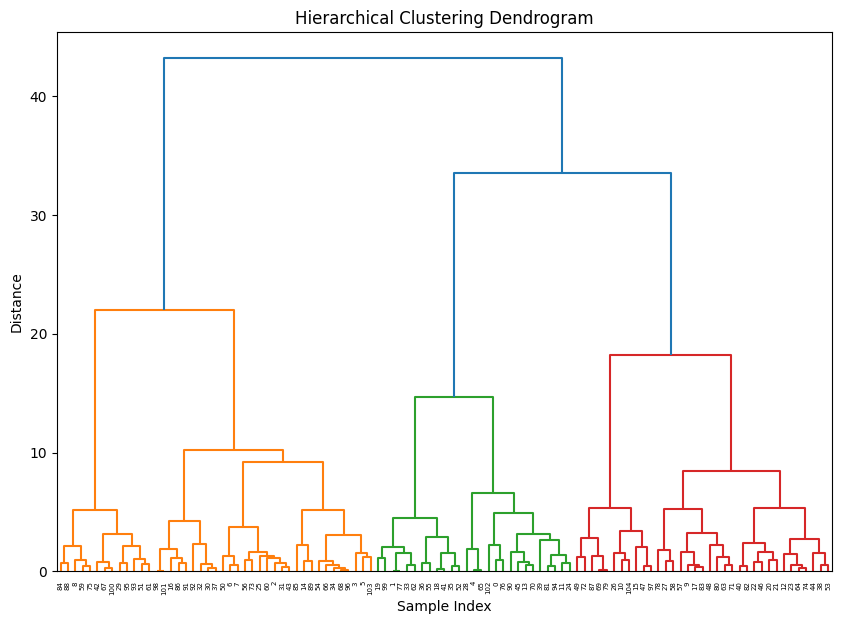

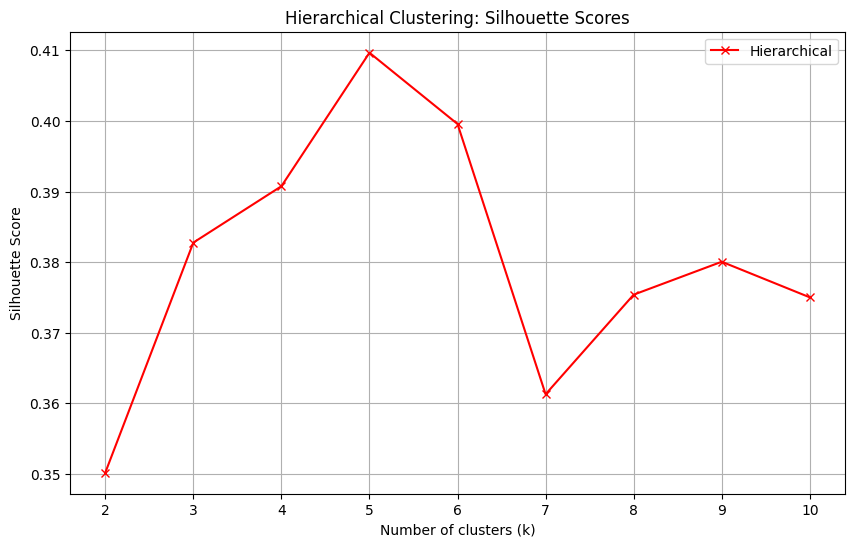


Cluster sizes in Hierarchical Clustering (k=5):
Cluster 1: 13 images
Cluster 2: 30 images
Cluster 3: 27 images
Cluster 4: 11 images
Cluster 5: 24 images


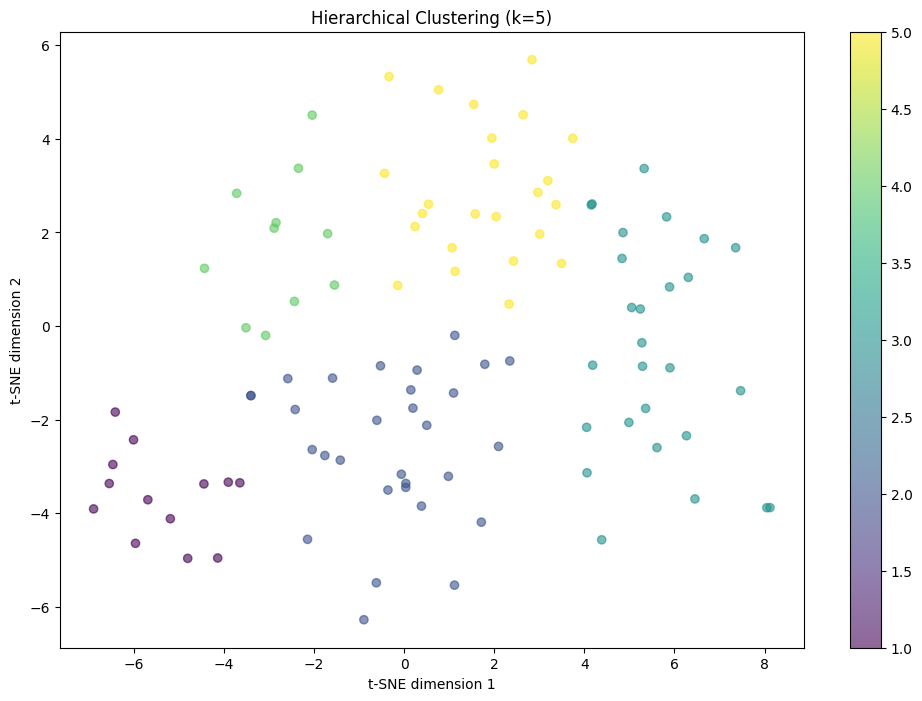

In [ ]:
# Compute linkage matrix using Ward's method
linkage_matrix = linkage(X_tsne_reshaped, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Evaluate different numbers of clusters (Silhouette Scores)
silhouette_scores_hc = []
K = range(2, 11)

for k in K:
    cluster_labels = fcluster(linkage_matrix, k, criterion='maxclust')
    silhouette_scores_hc.append(silhouette_score(X_tsne_reshaped, cluster_labels))

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores_hc, 'rx-', label='Hierarchical')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Clustering: Silhouette Scores')
plt.legend()
plt.grid(True)
plt.show()

# Set Optimal Number of Clusters
optimal_k = 5  # Set the best k based on previous analysis
hierarchical_clusters = fcluster(linkage_matrix, optimal_k, criterion='maxclust')

# Print cluster sizes
print("\nCluster sizes in Hierarchical Clustering (k={}):".format(optimal_k))
unique, counts = np.unique(hierarchical_clusters, return_counts=True)
for cluster, size in zip(unique, counts):
    print(f"Cluster {cluster}: {size} images")

# Visualize Clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title(f'Hierarchical Clustering (k={optimal_k})')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

# Save clustering results
clustering_results = []
for i in range(len(X_tsne)):
    clustering_results.append({
        'file': filenames[i],
        'x': float(X_tsne[i, 0]),
        'y': float(X_tsne[i, 1]),
        'cluster': int(hierarchical_clusters[i])
    })

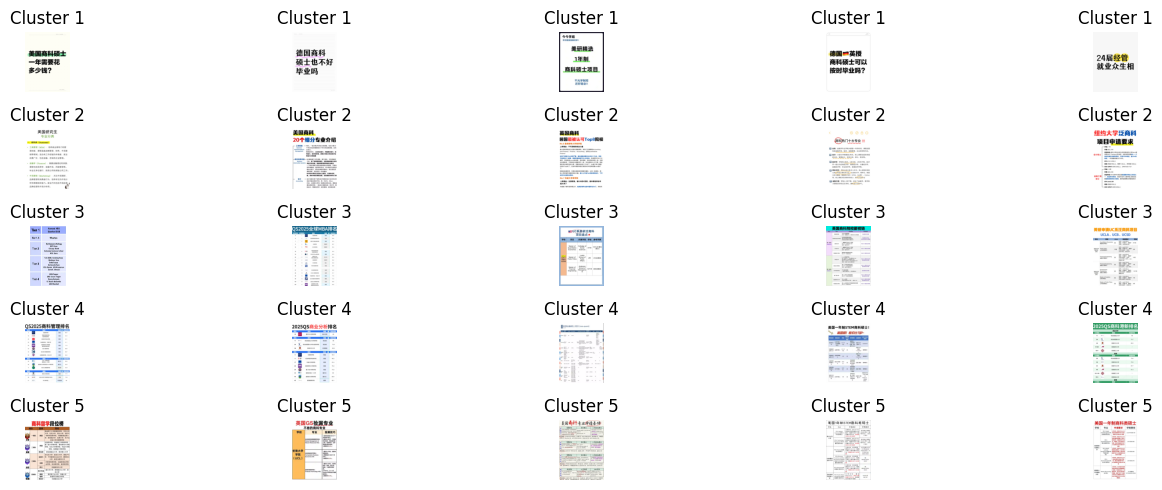

Cluster 1 center image: /content/drive/My Drive/Marketing Analytics Course Preparation/Qianyu/Modified Image & Text Analytics Code/Image Analytics/images/66eac588000000000c01a1dd.jpg
Cluster 2 center image: /content/drive/My Drive/Marketing Analytics Course Preparation/Qianyu/Modified Image & Text Analytics Code/Image Analytics/images/66697854000000001d014917.jpg
Cluster 3 center image: /content/drive/My Drive/Marketing Analytics Course Preparation/Qianyu/Modified Image & Text Analytics Code/Image Analytics/images/65eebf3b000000000d00e10a.jpg
Cluster 4 center image: /content/drive/My Drive/Marketing Analytics Course Preparation/Qianyu/Modified Image & Text Analytics Code/Image Analytics/images/671cd97a000000002401a003.jpg
Cluster 5 center image: /content/drive/My Drive/Marketing Analytics Course Preparation/Qianyu/Modified Image & Text Analytics Code/Image Analytics/images/66b5c9b10000000025033bff.jpg


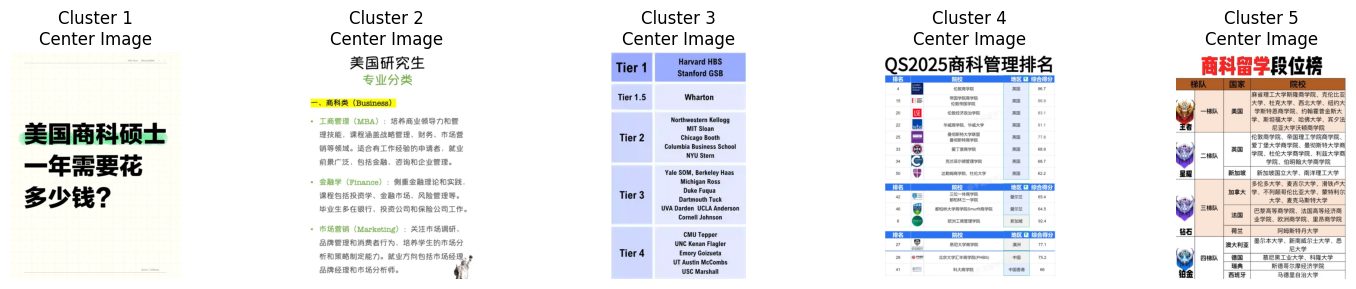

In [ ]:
# Function to find representative images for each cluster
def get_cluster_representatives(cluster_id, n_samples=5):
    cluster_points = X_tsne[hierarchical_clusters == cluster_id]
    cluster_files = np.array(filenames)[hierarchical_clusters == cluster_id]

    # Compute distances to cluster center
    center = np.mean(cluster_points, axis=0)
    distances = np.linalg.norm(cluster_points - center, axis=1)
    representative_indices = np.argsort(distances)[:n_samples]

    return [cluster_files[i] for i in representative_indices]

# Display representative images for each cluster
plt.figure(figsize=(15, 5))
for cluster in range(1, optimal_k + 1):
    representatives = get_cluster_representatives(cluster, 5)
    for idx, img_path in enumerate(representatives):
        plt.subplot(optimal_k, len(representatives), (cluster - 1) * len(representatives) + idx + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Cluster {cluster}')
plt.tight_layout()
plt.show()

# Function to find center image for each cluster
def get_center_image(cluster_id):
    cluster_mask = hierarchical_clusters == cluster_id
    cluster_points = X_tsne[cluster_mask]
    cluster_files = np.array(filenames)[cluster_mask]

    # Find the closest point to the cluster center
    center = np.mean(cluster_points, axis=0)
    distances = np.linalg.norm(cluster_points - center, axis=1)
    center_idx = np.argmin(distances)

    return cluster_files[center_idx]

# Display the center images of each cluster
plt.figure(figsize=(15, 3))
for cluster in range(1, optimal_k + 1):
    plt.subplot(1, optimal_k, cluster)
    center_image_path = get_center_image(cluster)

    # Read and display the image
    try:
        img = Image.open(center_image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Cluster {cluster}\nCenter Image')
        print(f"Cluster {cluster} center image: {center_image_path}")
    except Exception as e:
        print(f"Error loading image for cluster {cluster}: {e}")
        plt.text(0.5, 0.5, 'Image Load Error', ha='center', va='center')

plt.tight_layout()
plt.show()


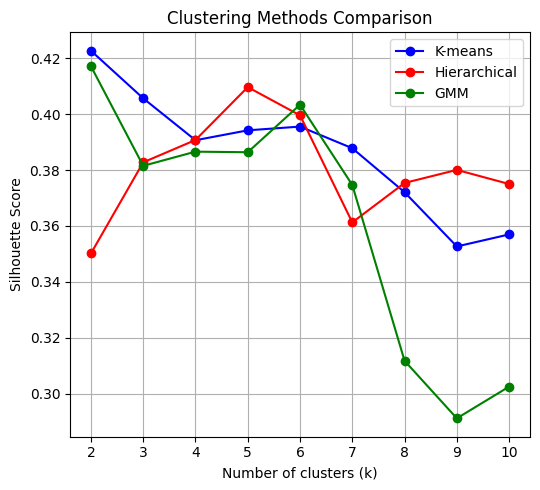


Optimal number of components according to BIC: 2

Cluster sizes in GMM:
Cluster 0: 52 samples
Cluster 1: 53 samples


In [ ]:
# Lists to store scores
silhouette_scores_gmm = []
bic_scores = []
aic_scores = []

# Try different numbers of components
K = range(2, 11)

for k in K:
    # Fit GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_tsne_reshaped)

    # Get cluster assignments
    labels = gmm.predict(X_tsne_reshaped)

    # Calculate scores
    silhouette_scores_gmm.append(silhouette_score(X_tsne_reshaped, labels))
    bic_scores.append(gmm.bic(X_tsne_reshaped))
    aic_scores.append(gmm.aic(X_tsne_reshaped))

# Create subplots for all metrics
plt.figure(figsize=(15, 5))

# Plot 1: Silhouette Score Comparison
plt.subplot(1, 3, 1)
plt.plot(K, silhouette_scores, 'bo-', label='K-means')
plt.plot(K, silhouette_scores_hc, 'ro-', label='Hierarchical')
plt.plot(K, silhouette_scores_gmm, 'go-', label='GMM')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Clustering Methods Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get the optimal number of components based on BIC
optimal_k_bic = K[np.argmin(bic_scores)]
print(f"\nOptimal number of components according to BIC: {optimal_k_bic}")

# Fit GMM with optimal components
optimal_gmm = GaussianMixture(n_components=optimal_k_bic, random_state=42)
optimal_gmm.fit(X_tsne_reshaped)
gmm_labels = optimal_gmm.predict(X_tsne_reshaped)

# Print cluster sizes
print("\nCluster sizes in GMM:")
unique, counts = np.unique(gmm_labels, return_counts=True)
for cluster, size in zip(unique, counts):
    print(f"Cluster {cluster}: {size} samples")


## Part 4: DEEPFACE

### 4.1 Define Face Analysis Function

In [ ]:
#import tensorflow as tf
def df_face_analysis(image_path, face_confidence_threshold=0.5):
    # Input: image_path
    # Perform face analysis using DeepFace
    try:
        result = []
        objs = DeepFace.analyze(
            img_path=image_path,
            actions=['age', 'gender', 'race', 'emotion'],
            enforce_detection=False,  # Avoid error if no face detected
            silent=True
        )
        for obj in objs:
            if obj.get('face_confidence', 0) < face_confidence_threshold:
                continue
            # Extract the dominant attributes
            dominant_gender = max(obj['gender'], key=obj['gender'].get)
            face_info = {
                'dominant_age': obj.get('age', 'N/A'),
                'dominant_gender': dominant_gender,  # Only "Man" or "Woman"
                'dominant_race': obj.get('dominant_race', 'N/A'),
                'dominant_emotion': obj.get('dominant_emotion', 'N/A'),
            }
            result.append(face_info)
        return result
    except Exception as e:
        print(f"Face analysis failed: {e}")

### 4.2 Implementation & Results

In [ ]:
face_result = []
for i in tqdm(paths_list, desc="Processing images"):
  info = df_face_analysis(i)
  if info == None:
    info = 'no face detected'
  face_result.append(info)

Processing images:   0%|          | 0/105 [00:00<?, ?it/s]

25-03-09 01:10:49 - age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5

  0%|          | 0.00/539M [00:00<?, ?B/s]
  2%|▏         | 9.96M/539M [00:00<00:05, 98.3MB/s]
  7%|▋         | 36.7M/539M [00:00<00:02, 196MB/s] 
 12%|█▏        | 64.0M/539M [00:00<00:02, 231MB/s]
 17%|█▋        | 89.7M/539M [00:00<00:01, 241MB/s]
 21%|██        | 114M/539M [00:00<00:01, 218MB/s] 
 25%|██▌       | 137M/539M [00:00<00:01, 209MB/s]
 30%|██▉       | 160M/539M [00:00<00:01, 215MB/s]
 34%|███▍      | 182M/539M [00:00<00:01, 211MB/s]
 38%|███▊      | 207M/539M [00:00<00:01, 222MB/s]
 43%|████▎     | 231M/539M [00:01<00:01, 226MB/s]
 48%|████▊     | 259M/539M [00:01<00:01, 240MB/s]
 53%|█████▎    | 283M/539M [00:01<00:01, 228MB/s]
 57%|█████▋    | 306M/539M [00:01<00:01, 221MB/s]
 62%|██████▏   | 334M/539M [00:01<00:00, 238MB/s]
 67%|██████▋   | 360M/539M [00:01<00:00, 243MB/s]
 71%|███████▏  | 385M/539M [00:01<00:00, 

25-03-09 01:10:59 - gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5

  0%|          | 0.00/537M [00:00<?, ?B/s]
  2%|▏         | 10.5M/537M [00:00<00:05, 104MB/s]
  6%|▌         | 32.0M/537M [00:00<00:03, 155MB/s]
 10%|▉         | 53.0M/537M [00:00<00:02, 166MB/s]
 14%|█▍        | 73.9M/537M [00:00<00:02, 165MB/s]
 18%|█▊        | 94.9M/537M [00:00<00:02, 179MB/s]
 22%|██▏       | 116M/537M [00:00<00:02, 189MB/s] 
 25%|██▌       | 137M/537M [00:00<00:02, 192MB/s]
 29%|██▉       | 158M/537M [00:00<00:02, 187MB/s]
 33%|███▎      | 179M/537M [00:00<00:01, 190MB/s]
 37%|███▋      | 200M/537M [00:01<00:01, 170MB/s]
 41%|████      | 221M/537M [00:01<00:01, 173MB/s]
 45%|████▍     | 242M/537M [00:01<00:01, 177MB/s]
 49%|████▉     | 263M/537M [00:01<00:01, 183MB/s]
 53%|█████▎    | 284M/537M [00:01<00:01, 185MB/s]
 57%|█████▋    | 305M/537M [00:01<00:01, 185MB/s]
 61%|██████    | 326M/537M [00:01<00

25-03-09 01:11:10 - race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5

  0%|          | 0.00/537M [00:00<?, ?B/s]
  1%|          | 3.67M/537M [00:00<00:14, 36.5MB/s]
  4%|▍         | 20.4M/537M [00:00<00:04, 113MB/s] 
  7%|▋         | 37.2M/537M [00:00<00:03, 138MB/s]
 10%|▉         | 51.4M/537M [00:00<00:03, 139MB/s]
 13%|█▎        | 68.2M/537M [00:00<00:03, 147MB/s]
 16%|█▌        | 84.9M/537M [00:00<00:02, 154MB/s]
 19%|█▉        | 102M/537M [00:00<00:02, 157MB/s] 
 22%|██▏       | 118M/537M [00:00<00:02, 159MB/s]
 25%|██▌       | 136M/537M [00:00<00:02, 162MB/s]
 28%|██▊       | 153M/537M [00:01<00:02, 165MB/s]
 32%|███▏      | 170M/537M [00:01<00:02, 166MB/s]
 35%|███▍      | 187M/537M [00:01<00:02, 166MB/s]
 38%|███▊      | 204M/537M [00:01<00:02, 166MB/s]
 41%|████      | 221M/537M [00:01<00:01, 162MB/s]
 44%|████▍     | 237M/537M [00:01<00:01, 161MB/s]
 47%|████▋     | 253M/537M 

25-03-09 01:11:20 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5

100%|██████████| 5.98M/5.98M [00:00<00:00, 67.8MB/s]
Processing images: 100%|██████████| 105/105 [04:31<00:00,  2.59s/it]


In [ ]:
# Initialize lists to store attributes
emotion = []
race = []
age = []
gender = []

# Extract attributes
for i in face_result:
    if isinstance(i, list):  # Ensure `i` is a list
        for j in i:
            if isinstance(j, dict):  # Ensure `j` is a dictionary
                if "dominant_emotion" in j:
                    emotion.append(j["dominant_emotion"])
                if "dominant_race" in j:
                    race.append(j["dominant_race"])
                if "dominant_age" in j:
                    age.append(j["dominant_age"])
                if "dominant_gender" in j:
                    gender.append(j["dominant_gender"])

# Function to count occurrences without using Counter
def count_occurrences(attribute_list, label):
    occurrence_dict = {}

    for item in attribute_list:
        if item:  # Ignore None values
            occurrence_dict[item] = occurrence_dict.get(item, 0) + 1

    # Print results
    print(f"\n📊 {label} Distribution:")
    for key, value in occurrence_dict.items():
        print(f"{key}: {value}")

    return occurrence_dict

# Print total extracted attributes
print(f"\n✅ Extracted Attributes:")
print(f"  Emotions: {len(emotion)}")
print(f"  Races: {len(race)}")
print(f"  Ages: {len(age)}")
print(f"  Genders: {len(gender)}")

# Count & Display distributions
emotion_count = count_occurrences(emotion, "Emotion")
race_count = count_occurrences(race, "Race")
age_count = count_occurrences(age, "Age")
gender_count = count_occurrences(gender, "Gender")


✅ Extracted Attributes:
  - Emotions: 8
  - Races: 8
  - Ages: 8
  - Genders: 8

📊 Emotion Distribution:
happy: 3
sad: 2
fear: 1
angry: 1
neutral: 1

📊 Race Distribution:
asian: 4
white: 4

📊 Age Distribution:
32: 2
31: 1
26: 1
27: 1
37: 1
30: 2

📊 Gender Distribution:
Woman: 5
Man: 3


## Part 5: Logo Detection

### 5.1 OpenAI Key

In [ ]:
client = OpenAI(api_key='')

### 5.2 Define Prompt for GPT

In [ ]:
nyu_detection_prompt_text = """Analyze the image and determine if it contains any New York University (NYU) branding elements or logos. Specifically look for:

1. The official NYU torch logo, which consists of:
   - A torch symbol with flames
   - The letters "NYU" in their distinctive font
   - The full text "New York University" if present
   - The official NYU purple color (#57068C)

2. Other NYU visual elements such as:
   - NYU's secondary logos or department-specific variations
   - NYU branded materials or signage
   - NYU building facades with clear university branding
   - Official NYU website headers or footers
   - NYU letterhead or official documents with university branding
   - NYU promotional materials with university identifiers

Respond with ONLY "Yes" or "No" based on whether ANY of these NYU elements are present in the image. Do not provide any additional explanation or description.

If the image contains something that merely mentions NYU in text but doesn't include official branding elements, respond with "No"."""


In [ ]:
# Function to encode the image in Base64 format
def encode_image(image_path):
    """Encodes an image to Base64 format for API input."""
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except Exception as e:
        print(f"⚠️ Error encoding image {image_path}: {e}")
        return None

# Function to perform logo detection using GPT-4o
def logo_detection(image_path, client, prompt_text):
    """
    Uses GPT-4o to detect if an image contains a logo.

    Returns:
        - True  → if logo is detected
        - False → if no logo detected
        - None  → if API response is unexpected
    """
    encoded_img = encode_image(image_path)
    if encoded_img is None:
        return None  # Skip processing if encoding fails

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt_text},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_img}"}},
                    ],
                }
            ],
        )

        # Extract response
        result = response.choices[0].message.content.strip().lower()

        if result in ["yes", "yes."]:
            return True
        elif result in ["no", "no."]:
            return False
        else:
            print(f"⚠️ Unexpected API response for {image_path}: {result}")
            return None

    except Exception as e:
        print(f"❌ Error processing image {image_path}: {e}")
        return None

# Process multiple images
result = []
failed_images = []  # Store images with unexpected responses

for i in tqdm(paths_list, desc="🔍 Processing images for logo detection"):
    logo = logo_detection(i, client, nyu_detection_prompt_text)

    if logo is True:
        result.append((i, 1))  # Logo detected
    elif logo is False:
        result.append((i, 0))  # No logo detected
    else:
        result.append((i, logo))  # Unexpected response
        failed_images.append(i)
        print(f"⚠️ Unexpected response for {i}: {logo}")

        # Display the image for manual review
        img = Image.open(i)
        plt.imshow(img)
        plt.axis("off")
        plt.title("⚠️ Manual Review Needed")
        plt.show()

# Display summary
print(f"\n✅ Process completed! {len(result)} images processed.")
if failed_images:
    print(f"⚠️ {len(failed_images)} images require manual review.")

🔍 Processing images for logo detection: 100%|██████████| 105/105 [03:26<00:00,  1.97s/it]


✅ Process completed! 105 images processed.


### 5.3 Implementation & Results


📁 Results saved to logo_detection_results.csv


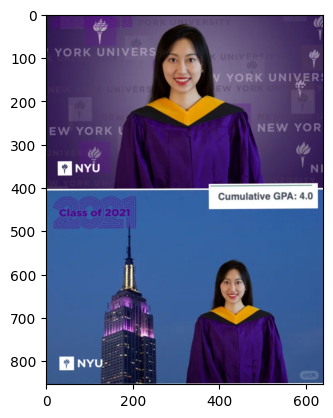

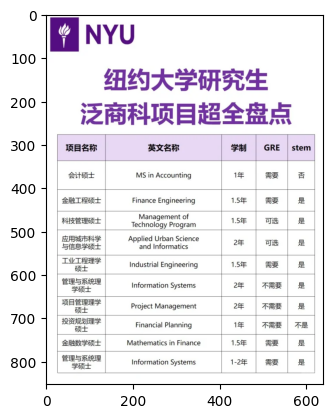

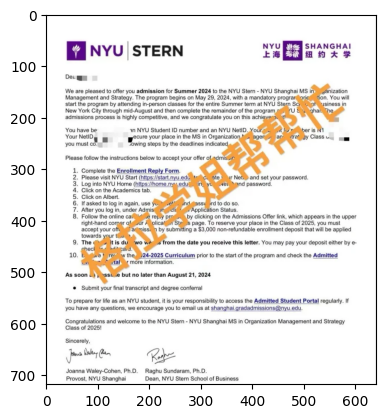

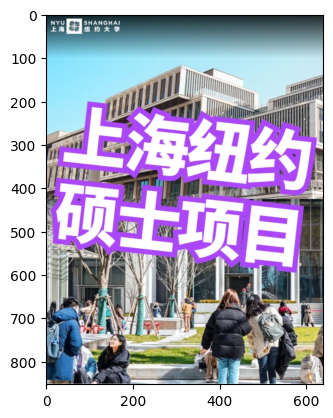

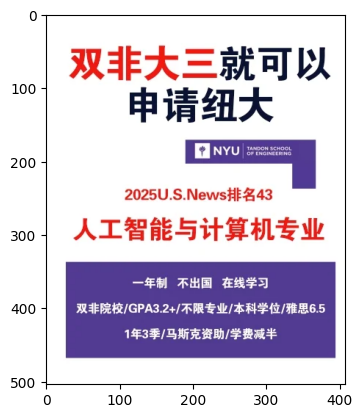

In [ ]:
# Save results to a CSV file
output_csv_path = "logo_detection_results.csv"

with open(output_csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Image_Path", "Logo_Detected"])  # Header
    writer.writerows(result)  # Write results

print(f"\n📁 Results saved to {output_csv_path}")

# Display detected images
for i in result:
  if i[1] == 1:
    img = Image.open(i[0])
    plt.imshow(img)
    plt.show()